In [1]:
# Install conda for colab.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
# Mount drive.
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
# Change directory to the location in which you would like to clone the github.
%cd gdrive/My Drive/ECBM Final Project New/Use this One/pnet_prostate_paper

/content/gdrive/My Drive/ECBM Final Project New/Use this One/pnet_prostate_paper


In [4]:
# Clone github.
!git clone https://github.com/marakeby/pnet_prostate_paper.git

In [5]:
# Create P-NET environment using environment01.yml. Runs in python 2.7.
!conda env create --name pnet_env --file=environment01.yml python==2.7 --force

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [6]:
# Activate P-NET environment.
!source activate pnet_env

In [5]:
import os
import sys
os.environ['PYTHONPATH'] = "/content/gdrive/My Drive/ECBM 4060 Final Project New/Use this One/pnet_prostate_paper"
! echo $PYTHONPATH

sys.path.extend(['/content/gdrive/My Drive/ECBM Final Project New/Use this One/pnet_prostate_paper'])

/content/gdrive/My Drive/ECBM 4060 Final Project New/Use this One/pnet_prostate_paper


In [11]:
# Change directory to pnet_prostate_paper/data. Install autogluon and import
# relevant libraries.
!cd ./data
!pip install autogluon
import data.data_access
from data.data_access import Data
import pandas as pd
import autogluon
from autogluon.tabular import TabularPredictor     

In [8]:
import data.data_access
from data.data_access import Data

In [9]:
# Load data for training, validation, and testing in an 80/10/10 split.
# Selected genes are those defined by the authors to be relevant to prostate
# cancer metastasis. These genes must also be part of the reactome pathway dataset.                                                                                             

selected_genes = 'tcga_prostate_expressed_genes_and_cancer_genes_and_memebr_of_reactome.csv'

data_params = {'id': 'ALL', 'type': 'prostate_paper',
               'params': {
                   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
                   'account_for_data_type': ['TMB'],
                   'drop_AR': False,
                   'cnv_levels': 3,
                   'mut_binary': False,
                   'balanced_data': False,
                   'combine_type': 'union',  # intersection
                   'use_coding_genes_only': True,
                   'selected_genes': selected_genes,
                   'selected_samples': None,
                   'training_split': 0,
               }
               }

data = Data(**data_params)
x_train, x_validate, x_test, y_train, y_validate, y_test, info_train, info_validate, info_test, cols = data.get_train_validate_test()

print('training shape: ')
print(x_train.shape, y_train.shape, info_train.shape, cols.shape)

print('validation shape: ')
print(x_validate.shape, y_validate.shape, info_validate.shape, cols.shape)

print('testing shape: ')
print(x_test.shape, y_test.shape, info_test.shape, cols.shape)


training shape: 
(807, 16270) (807,) (807,) (16270,)
validation shape: 
(102, 16270) (102,) (102,) (16270,)
testing shape: 
(102, 16270) (102,) (102,) (16270,)


In [12]:
# Prepare training data into a DataFrame for AutoML and visualization.
# Indices or rows are patient barcodes. Each column contains information
# about our selected genes of interest: mut_important (important mutation),
# cnv_del (copy number variation, deletion), or cnv_amp (copy number variation,
# amplification). Binary values (1/0) correspond to a positive or negative
# (i.e., if the mutation is important then the gene will have 1.0 in mut_important
# or if there is an observed deletion in the patient sample then cnv_del = 1.0).

# Add y_train to train_data DataFrame in a column 'is_Metastatic", corresponding
# to binary classification (i.e., 1 if the patient has metastatic cancer, 0 if 
# the patient has primary form of prostate cancer).

train_data = pd.DataFrame(x_train, columns=cols, index=info_train)
y_train = pd.Series(y_train)
y_train.values
train_data.columns = ['_'.join(col).strip() for col in train_data.columns.values]
train_data['is_Metastatic'] = y_train.values
train_data

,genomics_OR4C16_mut_important,genomics_OR4C16_cnv_del,genomics_OR4C16_cnv_amp,genomics_ADCY10_mut_important,genomics_ADCY10_cnv_del,genomics_ADCY10_cnv_amp,genomics_LIN28A_mut_important,genomics_LIN28A_cnv_del,genomics_LIN28A_cnv_amp,genomics_MARK4_mut_important,genomics_MARK4_cnv_del,genomics_MARK4_cnv_amp,genomics_MSI1_mut_important,genomics_MSI1_cnv_del,genomics_MSI1_cnv_amp,genomics_DCTN3_mut_important,genomics_DCTN3_cnv_del,genomics_DCTN3_cnv_amp,genomics_LIAS_mut_important,genomics_LIAS_cnv_del,genomics_LIAS_cnv_amp,genomics_CUL5_mut_important,genomics_CUL5_cnv_del,genomics_CUL5_cnv_amp,genomics_PACS1_mut_important,genomics_PACS1_cnv_del,genomics_PACS1_cnv_amp,genomics_NCKIPSD_mut_important,genomics_NCKIPSD_cnv_del,genomics_NCKIPSD_cnv_amp,genomics_GOPC_mut_important,genomics_GOPC_cnv_del,genomics_GOPC_cnv_amp,genomics_OR4X2_mut_important,genomics_OR4X2_cnv_del,genomics_OR4X2_cnv_amp,genomics_IFT27_mut_important,genomics_IFT27_cnv_del,genomics_IFT27_cnv_amp,genomics_SCN4B_mut_important,...,genomics_MED19_cnv_del,genomics_MED19_cnv_amp,genomics_JARID2_mut_important,genomics_JARID2_cnv_del,genomics_JARID2_cnv_amp,genomics_DMC1_mut_important,genomics_DMC1_cnv_del,genomics_DMC1_cnv_amp,genomics_GYPB_mut_important,genomics_GYPB_cnv_del,genomics_GYPB_cnv_amp,genomics_PREX2_mut_important,genomics_PREX2_cnv_del,genomics_PREX2_cnv_amp,genomics_PVR_mut_important,genomics_PVR_cnv_del,genomics_PVR_cnv_amp,genomics_POT1_mut_important,genomics_POT1_cnv_del,genomics_POT1_cnv_amp,genomics_LBR_mut_important,genomics_LBR_cnv_del,genomics_LBR_cnv_amp,genomics_INMT_mut_important,genomics_INMT_cnv_del,genomics_INMT_cnv_amp,genomics_SH3D19_mut_important,genomics_SH3D19_cnv_del,genomics_SH3D19_cnv_amp,genomics_NSUN6_mut_important,genomics_NSUN6_cnv_del,genomics_NSUN6_cnv_amp,genomics_AGBL2_mut_important,genomics_AGBL2_cnv_del,genomics_AGBL2_cnv_amp,genomics_VDAC1_mut_important,genomics_VDAC1_cnv_del,genomics_VDAC1_cnv_amp,account_for_TMB_TMB,is_Metastatic
P02-1562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.401197,0
AAPC-STID0000017668-Tumor-SM-2XU1W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.833213,0
TCGA-EJ-7792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.890372,0
TCGA-ZG-A9L1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135494,0
TCGA-G9-6378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.178054,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [14]:
# Use AutoML with 'good_quality_faster_inference_only_refit' preset to find the
# ML model with greatest performance on this dataset.
predictor = TabularPredictor(label='is_Metastatic', path="pnet_prostate_paper").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

INFO:root:Presets specified: ['good_quality_faster_inference_only_refit']
INFO:root:Warning: Training may take a very long time because `time_limit` was not specified and `train_data` is large (807 samples, 105.05 MB).
INFO:root:	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ...
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "pnet_prostate_paper/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.3.1
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    807
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 16270
INFO:autogluon.tabular.learner.default_learner:Preprocessing data ...
Level 25:autogluon.core.utils.utils:AutoGluon infers your prediction problem is: 'binary' (because

In [ ]:
# Save output!
!rsync -auzv pnet_prostate_paper /content/drive/My Drive/ECBM Final Project New

In [ ]:
# Summary table of AutoML model performances.
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBMLarge_BAG_L2   0.893432     109.751679  1325.853975                0.605567         122.949725            2      False         21
1            WeightedEnsemble_L3   0.893432     109.753781  1326.447640                0.002101           0.593665            3      False         22
2                LightGBM_BAG_L2   0.892193     109.737693  1292.091218                0.591581          89.186969            2      False         13
3              LightGBMXT_BAG_L2   0.892193     109.756689  1291.336611                0.610576          88.432362            2      False         12
4              LightGBMXT_BAG_L1   0.889715       0.600889    88.197802                0.600889          88.197802            1      False          1
5            WeightedEnsemble_L2   0.8

{'leaderboard':                            model  score_val  ...  can_infer  fit_order
 0           LightGBMLarge_BAG_L2   0.893432  ...      False         21
 1            WeightedEnsemble_L3   0.893432  ...      False         22
 2                LightGBM_BAG_L2   0.892193  ...      False         13
 3              LightGBMXT_BAG_L2   0.892193  ...      False         12
 4              LightGBMXT_BAG_L1   0.889715  ...      False          1
 5            WeightedEnsemble_L2   0.889715  ...      False         11
 6                 XGBoost_BAG_L2   0.888476  ...      False         20
 7                CatBoost_BAG_L2   0.884758  ...      False         16
 8                LightGBM_BAG_L1   0.883519  ...      False          2
 9        RandomForestEntr_BAG_L2   0.882280  ...      False         15
 10  RandomForestEntr_BAG_L2_FULL   0.882280  ...       True         37
 11       RandomForestGini_BAG_L2   0.881041  ...      False         14
 12  RandomForestGini_BAG_L2_FULL   0.881041  ...

In [15]:
# Create a test_data DataFrame, similar to train_data
test_data = pd.DataFrame(x_test, columns=cols, index=info_test)
y_test = pd.Series(y_test)
y_test.values
test_data.columns = ['_'.join(col).strip() for col in test_data.columns.values]
test_data

,genomics_OR4C16_mut_important,genomics_OR4C16_cnv_del,genomics_OR4C16_cnv_amp,genomics_ADCY10_mut_important,genomics_ADCY10_cnv_del,genomics_ADCY10_cnv_amp,genomics_LIN28A_mut_important,genomics_LIN28A_cnv_del,genomics_LIN28A_cnv_amp,genomics_MARK4_mut_important,genomics_MARK4_cnv_del,genomics_MARK4_cnv_amp,genomics_MSI1_mut_important,genomics_MSI1_cnv_del,genomics_MSI1_cnv_amp,genomics_DCTN3_mut_important,genomics_DCTN3_cnv_del,genomics_DCTN3_cnv_amp,genomics_LIAS_mut_important,genomics_LIAS_cnv_del,genomics_LIAS_cnv_amp,genomics_CUL5_mut_important,genomics_CUL5_cnv_del,genomics_CUL5_cnv_amp,genomics_PACS1_mut_important,genomics_PACS1_cnv_del,genomics_PACS1_cnv_amp,genomics_NCKIPSD_mut_important,genomics_NCKIPSD_cnv_del,genomics_NCKIPSD_cnv_amp,genomics_GOPC_mut_important,genomics_GOPC_cnv_del,genomics_GOPC_cnv_amp,genomics_OR4X2_mut_important,genomics_OR4X2_cnv_del,genomics_OR4X2_cnv_amp,genomics_IFT27_mut_important,genomics_IFT27_cnv_del,genomics_IFT27_cnv_amp,genomics_SCN4B_mut_important,...,genomics_MED19_mut_important,genomics_MED19_cnv_del,genomics_MED19_cnv_amp,genomics_JARID2_mut_important,genomics_JARID2_cnv_del,genomics_JARID2_cnv_amp,genomics_DMC1_mut_important,genomics_DMC1_cnv_del,genomics_DMC1_cnv_amp,genomics_GYPB_mut_important,genomics_GYPB_cnv_del,genomics_GYPB_cnv_amp,genomics_PREX2_mut_important,genomics_PREX2_cnv_del,genomics_PREX2_cnv_amp,genomics_PVR_mut_important,genomics_PVR_cnv_del,genomics_PVR_cnv_amp,genomics_POT1_mut_important,genomics_POT1_cnv_del,genomics_POT1_cnv_amp,genomics_LBR_mut_important,genomics_LBR_cnv_del,genomics_LBR_cnv_amp,genomics_INMT_mut_important,genomics_INMT_cnv_del,genomics_INMT_cnv_amp,genomics_SH3D19_mut_important,genomics_SH3D19_cnv_del,genomics_SH3D19_cnv_amp,genomics_NSUN6_mut_important,genomics_NSUN6_cnv_del,genomics_NSUN6_cnv_amp,genomics_AGBL2_mut_important,genomics_AGBL2_cnv_del,genomics_AGBL2_cnv_amp,genomics_VDAC1_mut_important,genomics_VDAC1_cnv_del,genomics_VDAC1_cnv_amp,account_for_TMB_TMB
TCGA-HC-A6HY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.178054
SC_9105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.709530
MO_1118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.761200
PROS12319B-SU2C-06115115-SM-4W2NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.510860
TCGA-KK-A8IH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.091042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [16]:
# Define a performance_scores function, as made in lecture notes, to output
# AutoML test performance.
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):

    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score.iloc[:,-1], average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [17]:
y_pred_score = predictor.predict_proba(test_data)
y_pred = predictor.predict(test_data)

In [18]:
# Test accuracy, auroc, balanced accuracy, and F1 score for best AutoML model
# In this case, this model is RandomForestEntr_BAG_L2_FULL (the first model
# in which can_infer is True.
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.9411764705882353,
 'auroc': 0.9770761245674742,
 'balanced_accuracy': 0.9191176470588236,
 'f1': 0.9401785714285714}

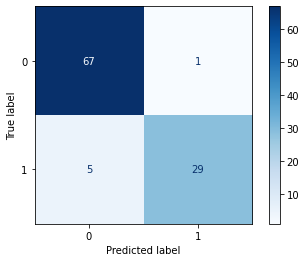

In [19]:
# Plot a confusion matrix to visualize performance on the test set.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=y_pred_score.columns.values)
disp.plot(cmap="Blues")